In [23]:
import pandas
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
import sklearn.impute 
import sklearn.preprocessing
from sklearn.preprocessing import OrdinalEncoder 


from sklearn.impute import SimpleImputer
%matplotlib inline

# Import data

In [24]:
data_train = pandas.read_csv('./Data/salary.train.csv', index_col='id')
data_test = pandas.read_csv('./Data/salary.test.csv', index_col='id')
data_live = pandas.read_csv('./Data/high_salary.live.csv', index_col='id')

# explore data

In [25]:
data_train.dtypes

social-security-number    float64
house-number              float64
age-group                 float64
workclass                  object
fnlwgt                    float64
education                  object
education-num             float64
marital-status             object
occupation                 object
relationship               object
race                       object
sex                        object
capitalgain               float64
capitalloss               float64
hoursperweek              float64
native-country-code        object
native-country             object
label                     float64
dtype: object

In [26]:
for feature in data_train:
    print(data_train[feature].value_counts())
    print('---------')

social-security-number
657404344.0    1
987463818.0    1
884327274.0    1
397372044.0    1
452805335.0    1
              ..
322171233.0    1
108941245.0    1
192389431.0    1
634986111.0    1
862188462.0    1
Name: count, Length: 16708, dtype: int64
---------
house-number
4668.0    8
3096.0    7
8866.0    7
7524.0    7
420.0     7
         ..
7492.0    1
2419.0    1
1327.0    1
883.0     1
3421.0    1
Name: count, Length: 8059, dtype: int64
---------
age-group
2.0    4515
1.0    4172
3.0    3310
0.0    2496
4.0    2220
Name: count, dtype: int64
---------
workclass
private             11278
self-emp-not-inc     1385
local-gov            1176
self-emp-inc          770
state-gov             707
federal-gov           547
without-pay             7
never-worked            3
Name: count, dtype: int64
---------
fnlwgt
125892.0    10
148995.0    10
111483.0     9
212894.0     9
193882.0     9
            ..
118149.0     1
467759.0     1
428584.0     1
295308.0     1
682947.0     1
Name: count,

from the previous cell we notice that we have some no-important features and redundant feature
1. Unique (no-important)
    - social-security-number
    - house-number
    - fnlwgt
2. Redundant 
    - education and education-num
    - native-contry-code and native-contry

- define category

In [27]:
numeric_features = [
    'social-security-number',
    'house-number',
    'fnlwgt'
]
categorical_features = [
    'age-group',
    'education',
    'education-num',
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country-code',
    'native-country',
    'capitalgain',  
    'capitalloss',  
    'hoursperweek' 
]

# Outlier and Missing value

### Define Outlier Detection Function
- Define function `count_outliers` to identify outliers.
It calculates the 1st quartile and 3rd quartile, 
1. finds the IQR `(IQR = Q_3 - Q_1)`, 
2. determines the lower_bound `(Q_1 - 1.5 \times IQR)` 
3. upper_bound `(Q_3 + 1.5 \times IQR)`. 

It returns the total count of values falling outside these bounds.


In [28]:
def count_outliers(series):
    """
    Calculates the number of outliers in a pandas Series using the 1.5*IQR rule.
    """
    try:
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        
        return len(outliers), lower_bound, upper_bound
    except Exception as e:
        # Handle cases where calculation might fail (e.g., non-numeric data)
        print(f"Error processing {series.name}: {e}")
        return 0, None, None

visualize Outlier 

- Training Data

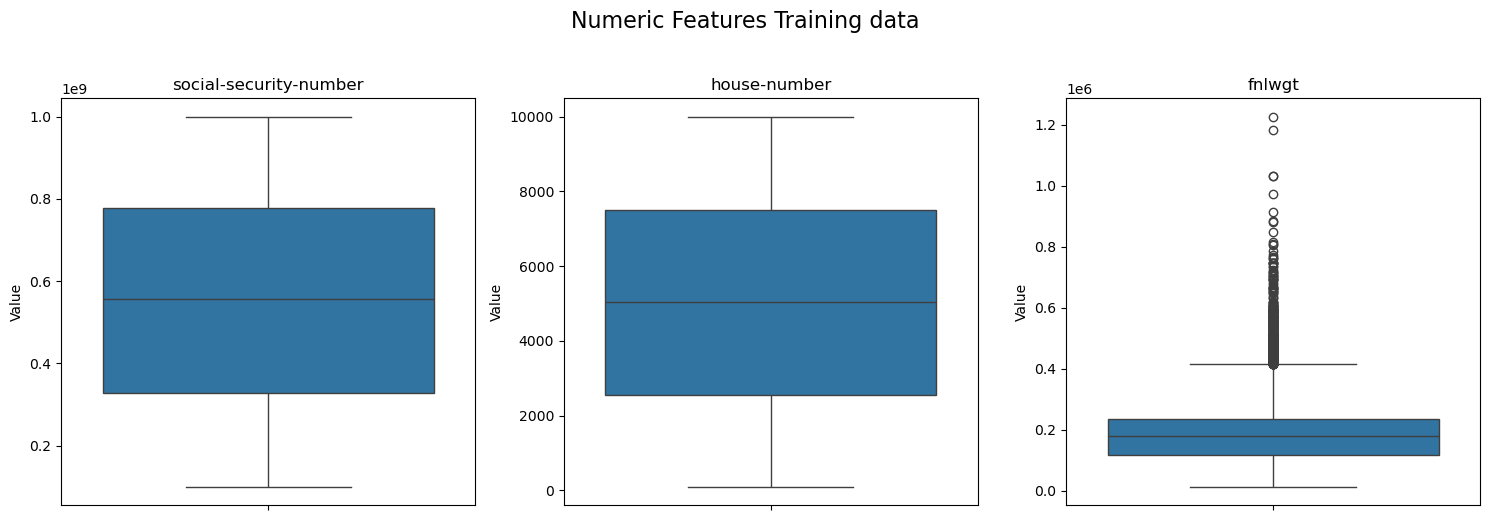

In [29]:
# Set up the plot
plt.figure(figsize=(15, 5))
plt.suptitle('Numeric Features Training data', fontsize=16, y=1.03) 

for i, feature in enumerate(numeric_features, 1):
    # Create a subplot for each feature
    plt.subplot(1, 3, i) 
    sns.boxplot(y=data_train[feature])
    plt.title(f'{feature}')
    plt.ylabel('Value')

plt.tight_layout() # Adjusts plots to prevent them from overlapping
plt.show() # Display the plot

- Testing Data

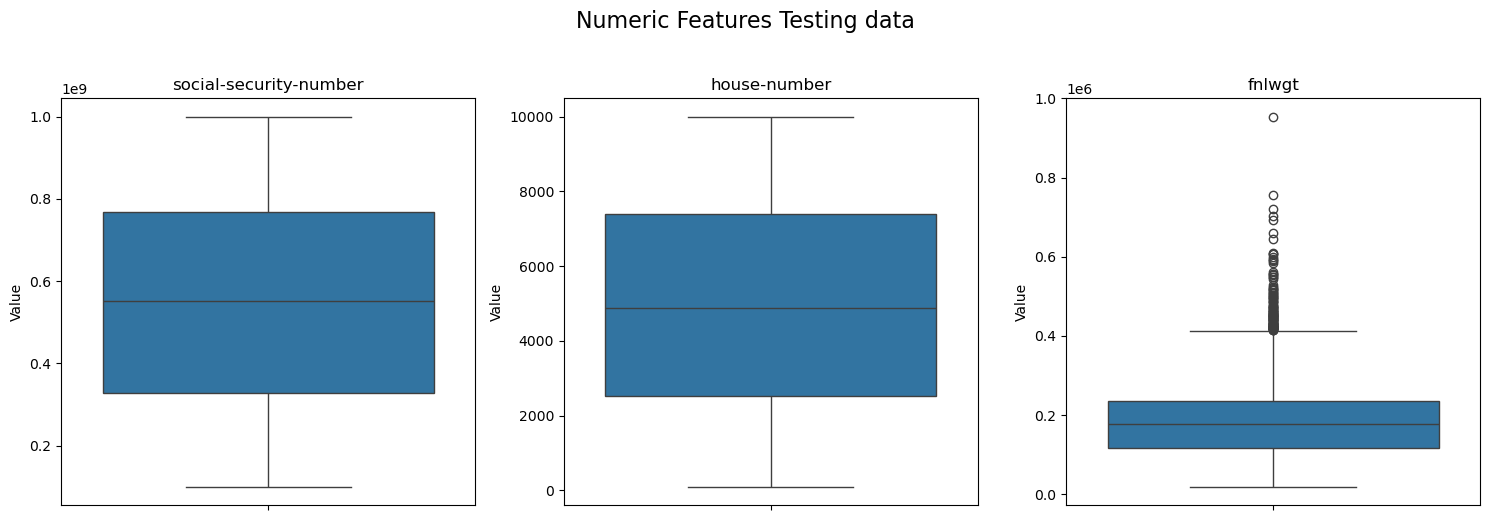

In [30]:
# Set up the plot
plt.figure(figsize=(15, 5))
plt.suptitle('Numeric Features Testing data', fontsize=16, y=1.03) 

for i, feature in enumerate(numeric_features, 1):
    # Create a subplot for each feature
    plt.subplot(1, 3, i) 
    sns.boxplot(y=data_test[feature])
    plt.title(f'{feature}')
    plt.ylabel('Value')

plt.tight_layout() # Adjusts plots to prevent them from overlapping
plt.show() # Display the plot

- Live data

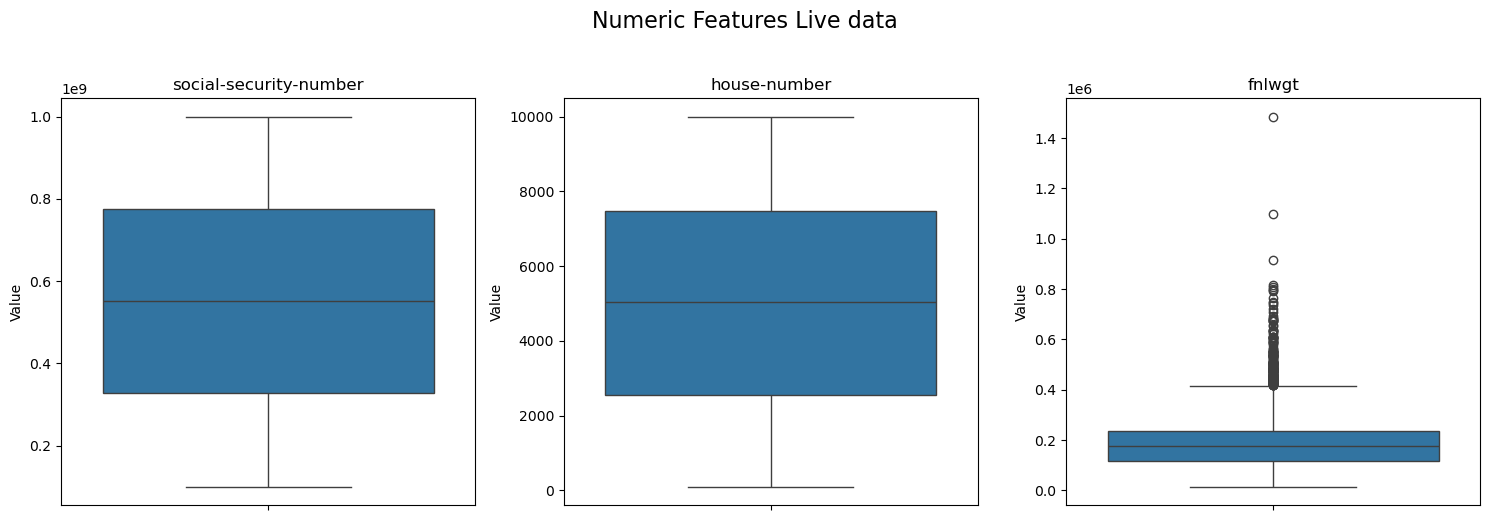

In [31]:
# Set up the plot
plt.figure(figsize=(15, 5))
plt.suptitle('Numeric Features Live data', fontsize=16, y=1.03) 

for i, feature in enumerate(numeric_features, 1):
    # Create a subplot for each feature
    plt.subplot(1, 3, i) 
    sns.boxplot(y=data_live[feature])
    plt.title(f'{feature}')
    plt.ylabel('Value')

plt.tight_layout() # Adjusts plots to prevent them from overlapping
plt.show() # Display the plot

### Detect missing value

- Training Data

In [32]:
data_train_numeric = data_train[numeric_features]
data_train_numeric.isna().sum()

social-security-number    12
house-number              20
fnlwgt                    17
dtype: int64

- Testing Data

In [33]:
data_test_numeric = data_test[numeric_features]
data_test_numeric.isna().sum()

social-security-number    2
house-number              7
fnlwgt                    6
dtype: int64

- Live data

In [34]:
data_live_numeric = data_live[numeric_features]
data_live_numeric.isna().sum()

social-security-number    2
house-number              9
fnlwgt                    4
dtype: int64

### Handle missing value and Outlier

We seeing that our numerical feature has an outlier

In [35]:
data_train['social-security-number'].value_counts()

social-security-number
657404344.0    1
987463818.0    1
884327274.0    1
397372044.0    1
452805335.0    1
              ..
322171233.0    1
108941245.0    1
192389431.0    1
634986111.0    1
862188462.0    1
Name: count, Length: 16708, dtype: int64